# Optimal Control for AFM State Preparation

## 1. Introduction

The following notebook gives an overview of the application of an optimal control method using Pulser. The announced objective is to achieve the preparation of the well-known antiferromagnetic state - see the section _Adiabatic preparation of an Anti-Ferromagnetic State_ in [the introductory tutorial](./creating.nblink#Adiabatic-preparation-of-an-Anti-Ferromagnetic-State) - on a squared configuration of neutral atoms using optimised pulses smoother than the usual ramps. We define by Anti-Ferromagnetic (AFM) state an equal mixture of the two "checkerboard" spin states.

<center>
<img src="../files/Optimization_checkerboard.png" width="500px"/>
</center>

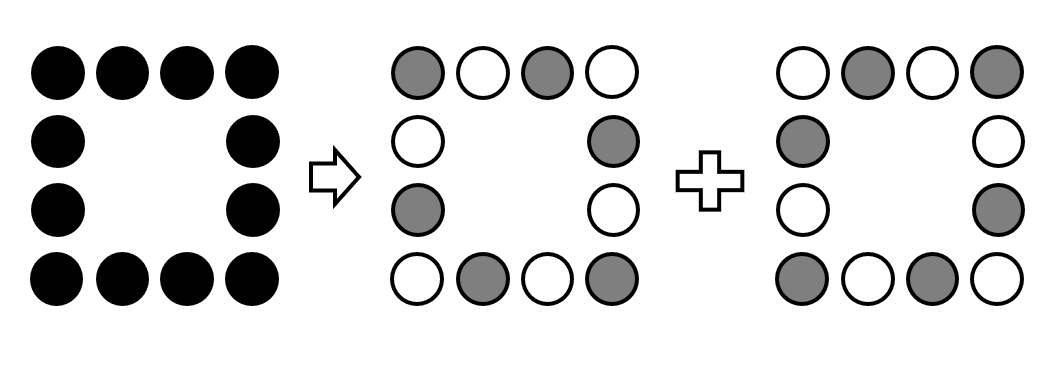

We begin by importing some basic modules as well as an optimisation function based on Gaussian processes `gp_minimize`. This notebook uses the `scikit-optimize` package, which has to be installed beforehand.

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import qutip
from skopt import gp_minimize

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipBackend
from pulser.waveforms import InterpolatedWaveform
from pulser.devices import AnalogDevice

## 2. System and Parameters

### 2.1 Pick a Device

As in _Adiabatic preparation of an Anti-Ferromagnetic State_, we will use an `AnalogDevice`, since we only need a `Rydberg.Global` channel.

In [2]:
device = AnalogDevice

### 2.2 Create a Register

Let's generate an AFM state on a chain of $12$ atoms. We will use a square register of $4\times 4$ atoms, each spaced by $5 \mu m$, with a central $2\times 2$ square of atoms missing. This avoids edge effects which alter the system dynamics.

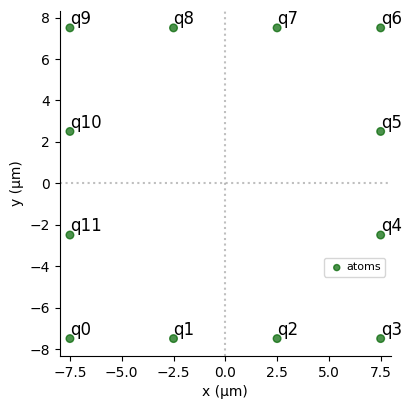

In [3]:
R_interatomic = 5  # µm

N_side = 4
coords = (
    [R_interatomic * np.r_[x, 0] for x in range(N_side - 1)]
    + [R_interatomic * np.r_[N_side - 1, y] for y in range(N_side - 1)]
    + [
        R_interatomic * np.r_[N_side - 1 - x, N_side - 1]
        for x in range(N_side - 1)
    ]
    + [R_interatomic * np.r_[0, N_side - 1 - y] for y in range(N_side - 1)]
)
reg = Register.from_coordinates(coords, prefix="q")
N = len(coords)
reg.draw()

Let's check that this register matches with the device's constraints by initializing the `Sequence`:

In [4]:
seq = Sequence(reg, device)

### 2.3 Pick the channels

The channel needed to prepare an AFM state is the `Rydberg.Global` channel. Let's declare this channel in the `Sequence`:

In [5]:
seq.declare_channel("ising", "rydberg_global")

### 2.4 Add the Pulses

We are going to use a Pulse composed of Interpolated Waveforms to define the evolution of $\Omega$ and $\delta$ along time.
The first parameter to define is the duration of the pulse, $T$:

In [6]:
T = 1000  # in µs

Then, we are going to describe $\Omega$ and $\delta$ by $2m$ parameters, that are $\{\Omega(t_i),\delta(t_i), i\in[1,m]\}$ with $t_i=T\times i/(m+1)$. These parameters are going to be tuned by the optimization algorithm. Therefore, the larger $m$ is, the more complex the pulse behaviour could be, but also the more resources are needed since the parameters space is expanding.

Let's start by initializing randomly the values for these $2m$ parameters, within the specifications of the declared `Rydberg.Global` channel.

In [7]:
# Size of the parameter space
m = 3

# Amp and detuning must respect the channel's specifications
tol = 1e-6  # within a certain tolerance

max_amp = seq.declared_channels["ising"].max_amp * (1 - tol)
Omega_max = min(max_amp, device.rabi_from_blockade(1.2 * R_interatomic))

U = 2 * Omega_max
max_det = seq.declared_channels["ising"].max_abs_detuning * (1 - tol)
delta_0 = -min(max_det, U)
delta_f = min(max_det, U)

# Random instance of the parameter space
amp_params = np.random.uniform(0, Omega_max, m)
det_params = np.random.uniform(delta_0, delta_f, m)

We define an interpolation function which takes as argument a set of parameters and returns the interpolated pulse associated. The interpolation is done through the `InterpolatedWaveform` class, which does monotonic cubic splines using `PchipInterpolator` by default.

<center>
<img src="../files/Optimization_interpolated.png" width="800"/>
</center>

Here, the starting and ending values of $\Omega$ and $\delta$ are fixed such that $\Omega (0) = \Omega(T) = 0$, $\delta(0) = \delta_0$ and $\delta(T) = \delta_f$.

In [8]:
def create_interp_pulse(amp_params, det_params):
    return Pulse(
        InterpolatedWaveform(T, [1e-9, *amp_params, 1e-9]),
        InterpolatedWaveform(T, [delta_0, *det_params, delta_f]),
        0,
    )

Let's use this function to add a pulse interpolating the randomly generated $2m$ parameters to the `Sequence`:

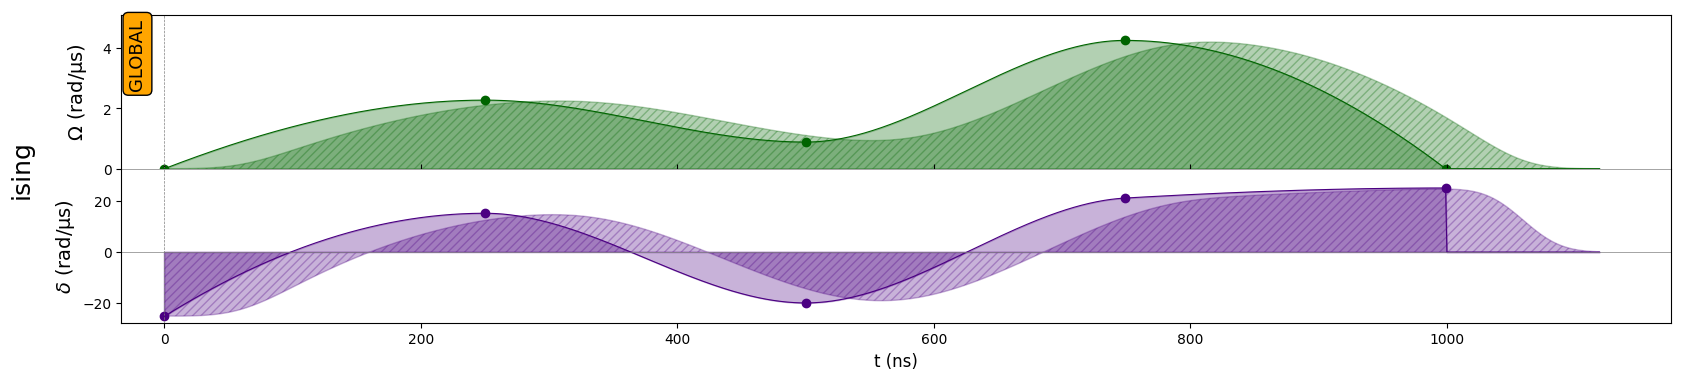

In [9]:
seq.add(create_interp_pulse(amp_params, det_params), "ising")
seq.draw()

### 2.5 Measurement and score function

Each Sequence generated with the $2m$ parameters has an associated result, obtained by measuring the state of the atoms at the end of the Sequence $N\_samples$ times:

Counter({'000000000000': 284, '000100000000': 46, '001000000000': 43, '000000010000': 40, '000000000001': 37, '000000000010': 35, '000000001000': 35, '000001000000': 35, '100000000000': 32, '010000000000': 31, '000010000000': 30, '000000100000': 27, '000000000100': 25, '010010000000': 10, '100000100000': 9, '001000010000': 8, '000001000100': 8, '001000001000': 7, '001000000010': 7, '001000000001': 7, '100100000000': 7, '000001001000': 6, '000000010100': 6, '100000001000': 6, '100000000010': 6, '000100001000': 6, '100010000000': 5, '001000100000': 5, '000000100001': 5, '100000000100': 5, '010000010000': 5, '000001000001': 5, '000001010000': 5, '000100000100': 5, '010000000100': 5, '010001000000': 5, '000100010000': 4, '101000000000': 4, '000000100100': 4, '010000100000': 4, '000010010000': 4, '000000000101': 4, '000000001001': 4, '100001000000': 4, '000000101000': 4, '000100000001': 4, '000010100000': 4, '000101000000': 4, '100000010000': 4, '000000010001': 3, '010000001000': 3, '000010

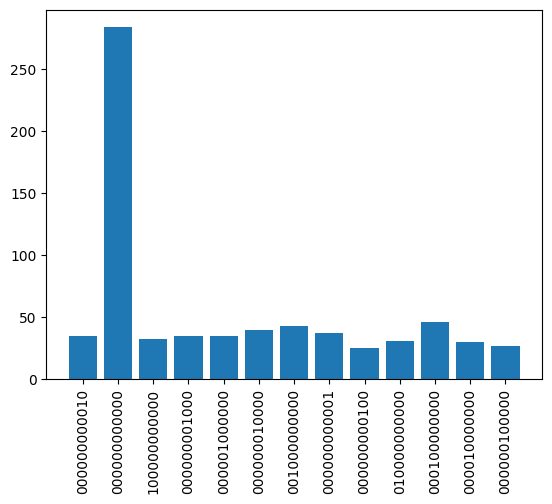

In [10]:
N_samples = 1000
simul = QutipBackend(seq)
results = simul.run()
counts = results.sample_final_state(N_samples)
print(counts)
# Let's plot the histogram associated to the measurements
# Let's select only the states that are measured more than 10 times
most_freq = {k: v for k, v in counts.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

The optimisation algorithm will browse the parameter space in search of an optimal shape of the pulse. In order to do so, we need to assign a score to each set of parameters based on the results we obtain at the end of the Sequence. 

With the optimization algorithm set to look for minimum, the AFM state should have a score of 0 and all other states strictly positive score. The score will be defined based on the **[Néel Structure Factor](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021070)**:

$$S_{\text{Néel}}=4 \times \sum_{\substack{1\le k, l\le N\\ (k,l) \neq (0,0)}} (-1)^{|k|+|l|} g^{(2)}(k,l)$$

Where $g^{(2)}$ is the **spin-spin correlation function**:

$$g^{(2)}(k,l)= \frac{1}{N_{k,l}}\sum_{(i,j) = (kR,lR)} \left[ \langle n_i n_j \rangle - \langle n_i \rangle \langle n_j \rangle \right]$$

The sum is over all the pairs of atoms $(i,j)$ whose distance is ${\bf r}_i - {\bf r}_j = (k R,l R)$ in the atomic array coordinate ($k$ and $l$ are integers, such that $-N\le k, l\le N$, and $R$ is the minimum interatomic distance between the atoms).




In [11]:
def occupation(j, N):
    up = qutip.basis(2, 0, dtype="CSR")
    prod = [qutip.qeye(2, dtype="CSR") for _ in range(N)]
    prod[j] = up * up.dag()
    return qutip.tensor(prod)


def get_corr_pairs(k, N):
    corr_pairs = [[i, (i + k) % N] for i in range(N)]
    return corr_pairs


def get_corr_function(k, N, state):
    corr_pairs = get_corr_pairs(k, N)
    operators = [occupation(j, N) for j in range(N)]
    covariance = 0
    for qi, qj in corr_pairs:
        covariance += qutip.expect(operators[qi] * operators[qj], state)
        covariance -= qutip.expect(operators[qi], state) * qutip.expect(
            operators[qj], state
        )
    return covariance / len(corr_pairs)


def get_neel_structure_factor(reg, state):
    N = len(reg.qubits)
    st_fac = 0
    for k in range(-N // 2, N // 2 + 1):
        kk = np.abs(k)
        st_fac += 4 * (-1) ** kk * get_corr_function(k, N, state)
    return st_fac

$S_{Néel}$ should reach its maximum for the AFM state. Let's check with the superposition of two checkerboard patterns:

In [12]:
# Create antiferromagnetic state as the superposition of the two checkerboard patterns:
AFM1 = qutip.tensor([qutip.basis(2, k % 2) for k in range(N)])
AFM2 = qutip.tensor([qutip.basis(2, (k + 1) % 2) for k in range(N)])
AFM_state = (AFM1 + AFM2).unit()

t1 = time.process_time()
S_max = get_neel_structure_factor(reg, AFM_state)
print("S_Neel(AFM state) =", S_max)
t2 = time.process_time()
print("computed in", (t2 - t1), "sec")

S_Neel(AFM state) = 13.0
computed in 0.0 sec


Since our optimizer will minimize the score function, we take $1-S_{Néel}$ for the score. The score function is then a function that:
- takes as input the $2m$ parameters describing $\Omega$ and $\delta$;
- generates the Sequence associated with these $2m$ parameters;
- submits this Sequence to a backend (here, we take `QutipBackend`);
- computes $1-S_{Néel}$ from the obtained results. 

In [13]:
def score(params):
    """Computes the score associated with a set of parameters."""
    seq = Sequence(reg, AnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(create_interp_pulse(params[:m], params[m:]), "ising")

    simul = QutipBackend(seq)
    results = simul.run()

    sampling = results.sample_final_state(N_samples=N_samples)
    sampled_state = sum(
        [
            np.sqrt(sampling[k] / N_samples) * qutip.ket(k, dtype="CSR")
            for k in sampling.keys()
        ]
    )

    F = get_neel_structure_factor(reg, sampled_state) / S_max

    return 1 - F

For the Sequence with random parameters, the score is:

In [14]:
score(np.r_[amp_params, det_params])

0.9688905384615386

## 3.  Optimisation

###  Bayesian search 
Bayesian optimisation method has two keywords: model and decide. 

It consists of both a statistical model that simulates the unknown landscape function $F$ and a decision maker, the acquisition function $a$, which indicates where the next evaluation will be most likely to enhance optimization. Two distinct stages are carried out. In the supervised training, $F$ is surveyed according to an initial space-filling pattern. For small-sized spaces, the probing points $\{x_i\}$ can be formed into a discrete grid efficiently covering the entire search space. However, as the number of dimensions grows, it becomes less resource-consuming to conduct a uniformly random sample of $n$ points. 

A prior surrogate model of $F$ is established knowing only its values $\{F(x_i)\}_{1:n}$ at those $n$ points. Then, in the research part, each new point of a remaining budget $M-n$ is iteratively selected and used to update the model. That model provides a posterior probability distribution $f$, which approximates $F$ at every $x$. Using Gaussian processes for the modelling enables to get normally distributed $f(x)$, fully described by only two parameters: a mean and a variance.

At each step of the algorithm, once the landscape  has been approximated over the search space, the acquisition function $a(x)$ can be updated, being completely determined by the  current distribution $f(x)$. $a$ relates to how desirable evaluating $F$ at $x$ is expected to be and its straightforward construction makes it a relatively inexpensive function to evaluate and thus to optimise. By focusing alternatively on exploration and exploitation, $a$ helps to locate the next optimal point to query, $x^{*}$. It might seem that we just traded one optimization problem for another, but the call cost of $a$ is usually derisory compared to the black box one. $F(x^{*})$ is then added to the known values of $F$ in order to refine the next model. 

After $M$ calls to $F$, the Bayesian algorithm outputs $x_{opt}$, the most "useful" point for the experiment, i.e. the supposed global minimum of $F$ or the point with the smallest mean in case of strong noise for instance. 

<center>
<img src="../files/Optimization_schema.png" width="700"/>
</center>

###  Parameters
We are probing the parameter space cons a $2m$-dimensional hyper-rectangle $[0,\Omega_{max}]^m\times[\delta_0,\delta_f]^m$ with $n_r$ training points and a total of $n_c$ probing points. The optimisation is achieved using `gp_minimize` from the module `scikit-optimize`.

In [15]:
bounds = [(0.0, Omega_max)] * m + [(delta_0, delta_f)] * m

n_r = 30
n_c = 120

RESULT = gp_minimize(
    score, bounds, n_random_starts=n_r, n_calls=n_c, verbose=False
)

### Performance

To ensure that the optimisation is well-designed, i.e. enough but not too many steps, we plot its performance in terms of the minimum score found after $n_{c}$ to the score function.

In [16]:
def sort_improv(RESULT):
    score_vals = RESULT.func_vals
    min = score_vals[0]
    score_list = []
    for s in score_vals:
        if s < min:
            min = s
            score_list.append(min)
        else:
            score_list.append(min)
    return score_list

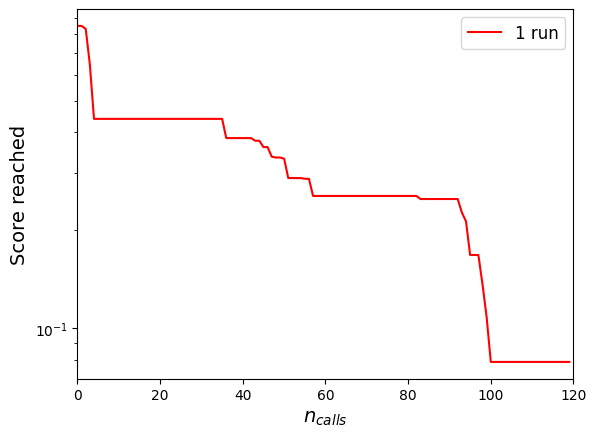

In [17]:
fig = plt.figure()
plt.semilogy(range(n_c), sort_improv(RESULT), "r-")
plt.xlabel(r"$n_{calls}$", fontsize=14)
plt.ylabel("Score reached", fontsize=14)
plt.legend(["1 run"], fontsize=12)
plt.xlim(0, n_c)
plt.show()

Since Bayesian optimisation is a stochastic algorithm, its results may vary between different runs. A 5-run average convergence of the algorithm for the same parameters is shown below. The scores achieved after the total number of calls all remain within an appreciable range.


<center>
<img src="../files/Optimization_Average_Conv.png" width="550"/>
</center>

### Optimised pulse
An interpolated pulse is produced based on the optimised parameters RESULT.x and then added to a new sequence.

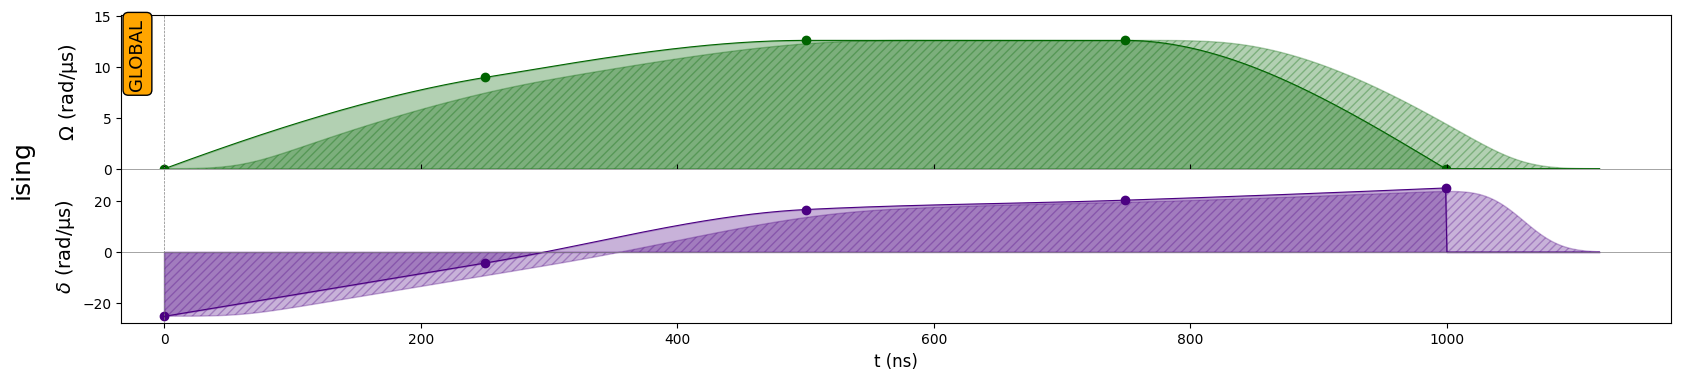

In [18]:
seq = Sequence(reg, AnalogDevice)
seq.declare_channel("ising", "rydberg_global")
P = create_interp_pulse(RESULT.x[:m], RESULT.x[m:])
seq.add(P, "ising")
seq.draw()

Most frequent bitstrings measured (1000 measurements) {'010101010101': 433, '101010101010': 409, '010101010100': 11}
S_Neel (final_sampled) = 11.661


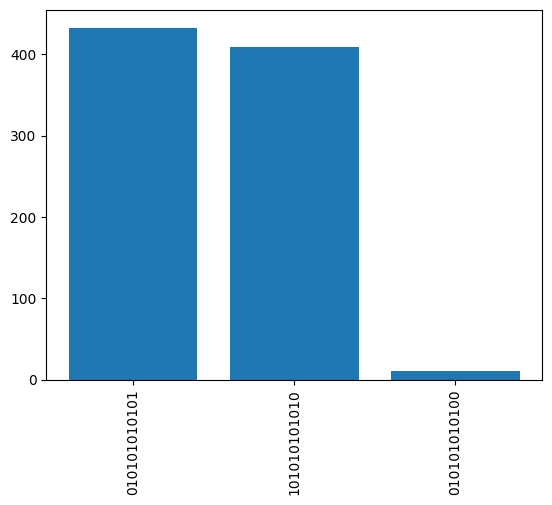

In [19]:
simul = QutipBackend(seq)
results = simul.run()
sampling = results.sample_final_state(N_samples=N_samples)
sampled_state = sum(
    [np.sqrt(sampling[k] / 1000) * qutip.ket(k) for k in sampling.keys()]
)

s_neel_sampled = np.round(get_neel_structure_factor(reg, sampled_state), 3)
most_freq = {k: v for k, v in sampling.items() if v > 10}

print(
    f"Most frequent bitstrings measured ({N_samples} measurements)", most_freq
)
print(f"S_Neel (final_sampled) = {s_neel_sampled}")
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

The final state is an Anti-Ferromagnetic state, as a superposition of the two checkerboard states, $\left|010101010101\right>$ and $\left|101010101010\right>$ !

<div class="alert alert-info">

**To go further**:

The optimization procedure presented here can be used to minimize other score functions. For instance, it can be used to find the solution of a [QUBO problem](./qubo.nblink) or the [Maximally Weighted Independent Set of a graph](./mwis.nblink).

</div>